<a href="https://colab.research.google.com/github/ssoyyoungg/practice/blob/main/CNN_STUDY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# transform
transform = transforms.ToTensor()

# dataset
train_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

# dataloader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 배치 하나 확인
images, labels = next(iter(train_loader))

print("images shape:", images.shape)
print("labels shape:", labels.shape)

100%|██████████| 9.91M/9.91M [00:00<00:00, 62.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.76MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 15.1MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.58MB/s]


images shape: torch.Size([64, 1, 28, 28])
labels shape: torch.Size([64])


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# gpu 사용가능하면 gpu 사용
print("device:", device)

class SimpleCNN(nn.Module):
  ##모델 클래스 정의
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        # (B,16,28,28)
        # 입력채널(MNIST는 흑백), 출력채널, 3x3 필터, 가로셀 크기 유지
        # 입력 = (B,1,28,28)
        # 출력 = (B,16,28,28)
        # Conv 출력 공식 (입력크기 - 컨널크기 + 2*패딩) / stride + 1
        self.pool  = nn.MaxPool2d(2, 2)
        # (B,16,14,14)
        # MaxPool2d(2, 2) => (kernel, stride)
        # (입력 - 커널)/stride+1
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        # (B,32,14,14)
        # pool -> (B,32,7,7)
        self.fc1   = nn.Linear(32*7*7, 128)
        self.fc2   = nn.Linear(128, 10)  # 0~9

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # (B,16,14,14)
        x = self.pool(F.relu(self.conv2(x)))   # (B,32,7,7)
        x = x.view(x.size(0), -1)              # (B, 32*7*7)
        x = F.relu(self.fc1(x))                # (B,128)
        x = self.fc2(x)                        # (B,10)  (로짓)
        return x

model = SimpleCNN().to(device)

# 방금 만든 배치로 출력 shape 확인
images, labels = images.to(device), labels.to(device)
logits = model(images)

print("logits shape:", logits.shape)   # 기대: (64, 10)
print("labels shape:", labels.shape)   # 기대: (64,)

device: cpu
logits shape: torch.Size([64, 10])
labels shape: torch.Size([64])


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# 1) device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# 2) model
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1   = nn.Linear(32*7*7, 128)
        self.fc2   = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # (B,16,14,14)
        x = self.pool(F.relu(self.conv2(x)))   # (B,32,7,7)
        x = x.view(x.size(0), -1)              # (B,1568)
        x = F.relu(self.fc1(x))                # (B,128)
        x = self.fc2(x)                        # (B,10)
        return x

model = SimpleCNN().to(device)

# 3) loss / optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 4) train 1 epoch
def train_one_epoch(model, loader):
    model.train()
    total_loss = 0.0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        loss = loss_fn(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)

    return total_loss / len(loader.dataset)

# 5) evaluate
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            logits = model(images)
            preds = logits.argmax(dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total

# 6) run
for epoch in range(1, 4):  # 일단 3 epoch만
    train_loss = train_one_epoch(model, train_loader)
    test_acc = evaluate(model, test_loader)
    print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Test Acc: {test_acc*100:.2f}%")


device: cpu
Epoch 1 | Train Loss: 0.2586 | Test Acc: 97.22%
Epoch 2 | Train Loss: 0.0652 | Test Acc: 98.40%
Epoch 3 | Train Loss: 0.0450 | Test Acc: 98.69%


모델 저장/ 불러오기

In [5]:
torch.save(model.state_dict(), "mnist_cnn.pth")
print("저장완료")

model2 = SimpleCNN().to(device)
model2.load_state_dict(torch.load("mnist_cnn.pth", map_location=device))
model2.eval()

acc2 = evaluate(model2, test_loader)
print(f"불러온 모델 정확도 : {acc2*100:.2f}%")

저장완료
불러온 모델 정확도 : 98.69%


오답 10개 뽑아서 시각화

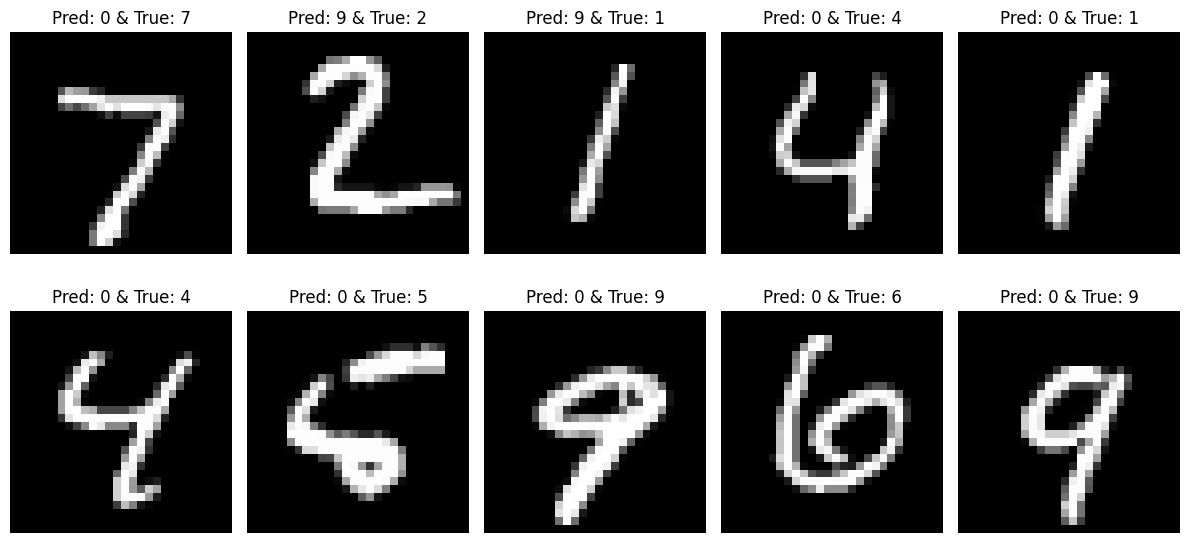

In [7]:
import matplotlib.pyplot as plt

model.eval()

wrong_images = []
wrong_preds = []
wrong_labels = []

with torch.no_grad():
  for images, labels in test_loader :
    images = images.to(device)
    labels = labels.to(device)

    logist = model(images)
    preds = logits.argmax(dim=1)

    wrong = preds != labels # 틀린 인덱스 찾기

    if wrong.any():
      wrong_images.extend(images[wrong].cpu())
      wrong_preds.extend(preds[wrong].cpu())
      wrong_labels.extend(labels[wrong].cpu())

    if len(wrong_images) >= 10:
      break

plt.figure(figsize=(12, 6))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(wrong_images[i].squeeze(), cmap="gray")
    plt.title(f"Pred: {wrong_preds[i].item()} & True: {wrong_labels[i].item()}")
    plt.axis("off")

plt.tight_layout()
plt.show()

Confusion Matrix

행 : 실제 정답

열 : 모델 예측

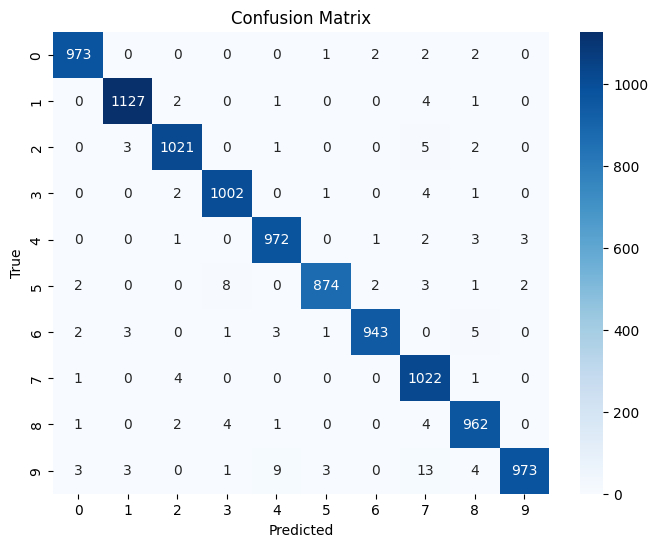

In [8]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        preds = logits.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# confusion matrix 계산
cm = confusion_matrix(all_labels, all_preds)

# 시각화
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


대각선 밖 숫자들을 확인하면 9->7 로 오측 한 경우가 가장 많은 것을 확인 가능하다

모델만 dropout 버전으로 바꾸기

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# 1) device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# 2) model
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1   = nn.Linear(32*7*7, 128)
        self.drop = nn.Dropout(p=0.5)
        self.fc2   = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # (B,16,14,14)
        x = self.pool(F.relu(self.conv2(x)))   # (B,32,7,7)
        x = x.view(x.size(0), -1)              # (B,1568)
        x = F.relu(self.fc1(x))                # (B,128)
        x = self.drop(x)
        x = self.fc2(x)                        # (B,10)
        return x

model = SimpleCNN().to(device)

# 3) loss / optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 4) train 1 epoch
def train_one_epoch(model, loader):
    model.train()
    total_loss = 0.0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        loss = loss_fn(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)

    return total_loss / len(loader.dataset)

# 5) evaluate
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            logits = model(images)
            preds = logits.argmax(dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total

# 6) run
for epoch in range(1, 4):  # 일단 3 epoch만
    train_loss = train_one_epoch(model, train_loader)
    test_acc = evaluate(model, test_loader)
    print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Test Acc: {test_acc*100:.2f}%")


device: cpu
Epoch 1 | Train Loss: 0.3542 | Test Acc: 97.62%
Epoch 2 | Train Loss: 0.1243 | Test Acc: 98.47%
Epoch 3 | Train Loss: 0.0969 | Test Acc: 98.58%


Dropout은 과적합을 줄이는 용도라 MNIST처럼 쉬운 데이터에서는 성능 차이가 크게 안날수 있음

채널 수 늘려보기

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# 1) device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# 2) model
class SimpleCNN_Bigger(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1   = nn.Linear(64*7*7, 128)
        self.fc2   = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # (B,16,14,14)
        x = self.pool(F.relu(self.conv2(x)))   # (B,32,7,7)
        x = x.view(x.size(0), -1)              # (B,1568)
        x = F.relu(self.fc1(x))                # (B,128)
        x = self.fc2(x)                        # (B,10)
        return x

model = SimpleCNN_Bigger().to(device)
optimizer =optim.Adam(model.parameters(), lr=1e-3)

# 3) loss / optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 4) train 1 epoch
def train_one_epoch(model, loader):
    model.train()
    total_loss = 0.0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        loss = loss_fn(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)

    return total_loss / len(loader.dataset)

# 5) evaluate
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            logits = model(images)
            preds = logits.argmax(dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total

# 6) run
for epoch in range(1, 4):  # 일단 3 epoch만
    train_loss = train_one_epoch(model, train_loader)
    test_acc = evaluate(model, test_loader)
    print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Test Acc: {test_acc*100:.2f}%")


device: cpu
Epoch 1 | Train Loss: 0.1681 | Test Acc: 98.22%
Epoch 2 | Train Loss: 0.0525 | Test Acc: 98.80%
Epoch 3 | Train Loss: 0.0345 | Test Acc: 98.94%


채널수 는 곧 표현력이라서

채널수 늘리니까 MNIST에서도 성능이 소폭 상승

softmax 확률 시각화

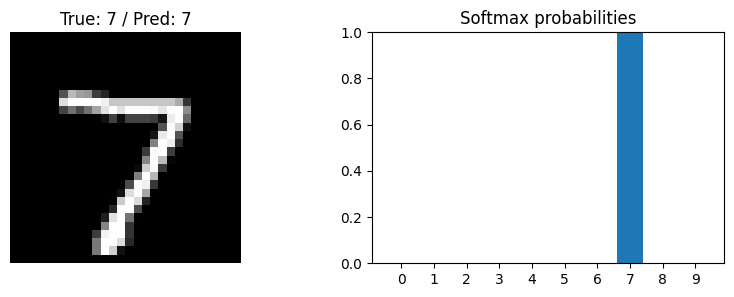

확률 Top3: torch.return_types.topk(
values=tensor([1.0000e+00, 1.2599e-06, 4.6408e-08]),
indices=tensor([7, 3, 9]))


In [16]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

model.eval()

images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

idx = 0  # <- 숫자 바꿔가며 보기 (0~63)

x = images[idx:idx+1]     # (1,1,28,28)
y = labels[idx].item()

with torch.no_grad():
    logits = model(x)               # (1,10)
    probs = F.softmax(logits, dim=1).squeeze().cpu()  # (10,)

pred = probs.argmax().item()

plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
plt.imshow(x.squeeze().cpu(), cmap="gray")
plt.title(f"True: {y} / Pred: {pred}")
plt.axis("off")

plt.subplot(1,2,2)
plt.bar(range(10), probs.numpy())
plt.xticks(range(10))
plt.ylim(0, 1)
plt.title("Softmax probabilities")
plt.show()

print("확률 Top3:", torch.topk(probs, 3))


7,3,9 일수 있는 확률이 나옴

1.0 (과신하고 있는 상태) / 0.0000012599 / 0.000000046

과신하는 상태가 왜 위험한지?

모델이 자신의 불확실성을 표현하지 못함

오답 샘플을 일부러 찾아보기

In [17]:
model.eval()
wrong_idx = None

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        preds = logits.argmax(dim=1)

        wrong = (preds != labels)
        if wrong.any():
            wrong_idx = wrong.nonzero(as_tuple=True)[0][0].item()
            # 배치 안에서 idx라서, 바로 시각화하려면 이 배치의 images/labels를 사용해야 함
            print("이 배치에서 오답 idx:", wrong_idx, "True:", labels[wrong_idx].item(), "Pred:", preds[wrong_idx].item())
            break


이 배치에서 오답 idx: 29 True: 2 Pred: 3


2를 3으로 착각했다는 뜻

오답 샘플 확인

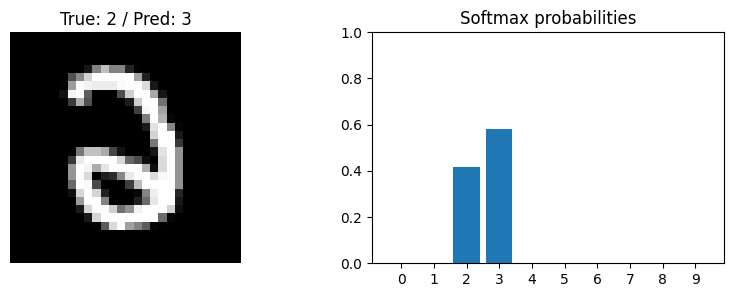

확률 Top3: torch.return_types.topk(
values=tensor([5.8079e-01, 4.1853e-01, 5.4246e-04]),
indices=tensor([3, 2, 8]))


In [18]:
idx = 29  # 방금 찾은 오답 idx

x = images[idx:idx+1]
y = labels[idx].item()

with torch.no_grad():
    logits = model(x)
    probs = F.softmax(logits, dim=1).squeeze().cpu()

pred = probs.argmax().item()

plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
plt.imshow(x.squeeze().cpu(), cmap="gray")
plt.title(f"True: {y} / Pred: {pred}")
plt.axis("off")

plt.subplot(1,2,2)
plt.bar(range(10), probs.numpy())
plt.xticks(range(10))
plt.ylim(0, 1)
plt.title("Softmax probabilities")
plt.show()

print("확률 Top3:", torch.topk(probs, 3))


In [20]:
model.eval()

global_index = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        preds = logits.argmax(dim=1)

        wrong = preds != labels

        if wrong.any():
            batch_idx = wrong.nonzero(as_tuple=True)[0][0].item()
            dataset_idx = global_index + batch_idx

            print("배치 idx:", batch_idx)
            print("데이터셋 전체 idx:", dataset_idx)
            print("True label:", labels[batch_idx].item())
            print("Pred label:", preds[batch_idx].item())

            break

        global_index += images.size(0)

배치 idx: 29
데이터셋 전체 idx: 221
True label: 2
Pred label: 3


In [21]:
img, lab = test_dataset[221]
print("원본 데이터셋 라벨:", lab)

원본 데이터셋 라벨: 2


CIFAR-10 (진짜 이미지 분류)

CIFAR-10 데이터 로드

In [22]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

transform = transforms.ToTensor()

train_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

images, labels = next(iter(train_loader))
print("images:", images.shape)  # 기대: (64, 3, 32, 32)
print("labels:", labels.shape)  # 기대: (64,)

100%|██████████| 170M/170M [00:02<00:00, 66.4MB/s]


images: torch.Size([64, 3, 32, 32])
labels: torch.Size([64])


CIFAR용 CNN 모델 (입력 채널 3 으로 변경)

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

class CIFAR_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  # ⭐ 3채널!
        self.pool  = nn.MaxPool2d(2, 2)              # 32→16
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # 16 유지
        # pool 한 번 더: 16→8
        self.fc1   = nn.Linear(64*8*8, 128)
        self.fc2   = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # (B,32,16,16)
        x = self.pool(F.relu(self.conv2(x)))  # (B,64,8,8)
        x = x.view(x.size(0), -1)             # (B,64*8*8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)                       # (B,10)
        return x

model = CIFAR_CNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


device: cpu


학습/평가 함수

In [24]:
def train_one_epoch(model, loader):
    model.train()
    total_loss = 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        logits = model(images)
        loss = loss_fn(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)

    return total_loss / len(loader.dataset)

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total


In [25]:
for epoch in range(1, 3):
    train_loss = train_one_epoch(model, train_loader)
    test_acc = evaluate(model, test_loader)
    print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Test Acc: {test_acc*100:.2f}%")


Epoch 1 | Train Loss: 1.5589 | Test Acc: 55.00%
Epoch 2 | Train Loss: 1.1838 | Test Acc: 61.65%
